In [18]:
import findspark
import pyspark
import numpy as np
import pyspark.sql.functions as sqlFunctions
import matplotlib.pyplot as plt

from operator import add
from pyspark.sql import SQLContext

%matplotlib inline

In [19]:
findspark.init()
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

In [20]:
# Full original training set
raw_full_train = sc.textFile("dac/train.txt")

# Final test set split
raw_final_test = sc.textFile("dac/split/test.txt")  # Do not touch during training

# Training set splits
raw_test_3m = sc.textFile("dac/split/test_3m.txt")
raw_train_5m = sc.textFile("dac/split/train_5m.txt")
raw_validation_2m = sc.textFile("dac/split/train_5m.txt")

# Debug set
raw_small_train = sc.textFile("dac/small-train.txt")

In [21]:
def convert_value(index, value):
    if index < 14:
        return int(value) if value else None
    else:
        return value if value else None

def convert_line(line):
    return [convert_value(i, value) for i, value in enumerate(line.split("\t"))]

In [22]:
# Change the data types of the datasets so that the RDD's include Int's and Strings. 
full_train = raw_full_train.map(convert_line)
final_test = raw_final_test.map(convert_line)
test_3m = raw_test_3m.map(convert_line)
train_5m = raw_train_5m.map(convert_line)
validation_2m = raw_validation_2m.map(convert_line)

debug = raw_small_train.map(convert_line)

In [23]:
# Label data histogram
debug.map(lambda row: row[0]).histogram([0,1,2])

([0, 1, 2], [77337, 22663])

In [149]:
def int_column_histogram(col_num, col):
    bins, counts = col.histogram(10)
    total = sum(counts)    
    print "Column %d histogram\n\tBins=%s\n\tCounts=%s (total=%d)" % (col_num, bins, counts, total)
    # TODO: display graph of histogram
    # TODO: better buckets for histogram (smart sub-dividing)
        #sum the counts
        #max of the counts
        #if  > 25%
    return bins,counts

def int_columns_histograms(data):
    bins=[]; counts=[]
    for i, col in enumerate(column_iter(debug)):
        col_num = i + 1
        if is_integer_col_num(col_num):
            bins1,counts1 = int_column_histogram(col_num, col)
            bins.append(bins1) #bin values
            counts.append(counts1) #count inside bins
            
    return bins,counts

def bin_range_labels(bins):
    #Nicely display these. 
    return ["%s---%s" % ("{:.1e}".format((bins[i])),"{:.2E}".format((bins[i+1]))) for i in range(len(bins) - 1)]

#def bin_range_labels(bins):
    #Nicely display these. 
#   return ["%s---%s" % (bins[i], bins[i + 1]) for i in range(len(bins) - 1)]

In [130]:
def get_column_num(data, col_num):
    return data.map(lambda row: row[col_num])

def column_filter_null(column):
    return column.filter(lambda row: row is not None)

def column_count(data):
    return len(data.take(1)[0])

def is_integer_col_num(col_num):
    return col_num > 1 and col_num < 15

def is_label_col_num(col_num):
    return col_num == 1

def is_categorical_col_num(col_num):
    return col_num > 15

def column_iter(data):
    for i in range(column_count(data)):
         yield get_column_num(data, i)

In [104]:
def cat_columns_histogram(data):
    for i, col in enumerate(column_iter(debug)):
        col_num = i + 1
        if is_categorical_col_num(col_num):
            key_counts = col.map(lambda key: (key, 1)).reduceByKey(add)
            sorted_counts = sorted(key_counts.collect(), key=lambda t: t[1], reverse=True)
            labels = [v[0] for v in sorted_counts]
            counts = [v[1] for v in sorted_counts]
            # TODO: graph these counts
            # TODO: truncate at something larger than 5
            print labels[:10], counts[:10], "Remaining", sum(counts[10:])
            
            return labels[:10],counts[:10],sum(counts[10:])

In [101]:


x,y = int_columns_histograms(debug)

Column 2 histogram
	Bins=[0.0, 55.6, 111.2, 166.8, 222.4, 278.0, 333.6, 389.2, 444.8, 500.40000000000003, 556]
	Counts=[55236, 295, 34, 10, 5, 3, 2, 0, 1, 1] (total=55587)
Column 3 histogram
	Bins=[-2.0, 1850.4, 3702.8, 5555.200000000001, 7407.6, 9260.0, 11112.400000000001, 12964.800000000001, 14817.2, 16669.600000000002, 18522]
	Counts=[98530, 1397, 52, 12, 7, 0, 1, 0, 0, 1] (total=100000)
Column 4 histogram
	Bins=[0.0, 6553.5, 13107.0, 19660.5, 26214.0, 32767.5, 39321.0, 45874.5, 52428.0, 58981.5, 65535]
	Counts=[80863, 11, 1, 20, 0, 0, 0, 0, 1, 2] (total=80898)
Column 5 histogram
	Bins=[0.0, 41.7, 83.4, 125.10000000000001, 166.8, 208.5, 250.20000000000002, 291.90000000000003, 333.6, 375.3, 417]
	Counts=[79210, 1178, 44, 8, 12, 6, 5, 0, 0, 3] (total=80466)
Column 6 histogram
	Bins=[0.0, 174112.8, 348225.6, 522338.39999999997, 696451.2, 870564.0, 1044676.7999999999, 1218789.5999999999, 1392902.4, 1567015.2, 1741128]
	Counts=[93216, 1145, 491, 218, 88, 44, 19, 11, 5, 3] (total=95240)
C

In [144]:
# This represents the Histograms for Category Features. 
# For Integer Feature we do not compute "Other Values"
# 
# x_values = 1D array of the x_values {bins OR category names}
# y_values = 1D array of the y_values {counts of uniques in bins or category name}
# isCategory = True if feature is category. 
#            = False if feature is integer.
# Z_other_values = sum of the counts of the remaining categories for category feature.
#
#
def disp_Histogram(x_values,y_values,isCategory, column_numb,z_other_value=0):
        x1 = np.array([0,1,2,3,4,5,6,7,8,9])
        x2 = []
        
        if (isCategory):
            type_of_feature = "Category"
            x_label = "Category as a Hashed value"
            #Add Other column
            for i in x_values: 
                x2.append(str(i))
            x1 = np.append(x1,10)
            x2.append('Other')
            y.append(z_other_value)

        else: 
            type_of_feature = "Integer"
            x_label = "Bins of Integer values"
            x2 = bin_range_labels(x_values)

        
        plt.title('%s Feature %s Histogram' % (type_of_feature,column_numb))
        plt.ylabel('Count of values')
        plt.xlabel('The %s' % x_label)
        print ("X: %s, Y: %s" % (x1,y_values))
        plt.xticks(x1, x2,rotation=45)
        plt.bar(x1, y_values,log=True)
        plt.show()

    

X: [0 1 2 3 4 5 6 7 8 9], Y: [93216, 1145, 491, 218, 88, 44, 19, 11, 5, 3]


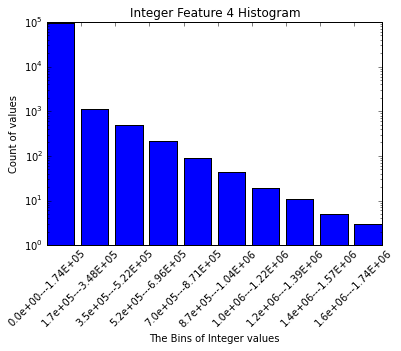

In [162]:
# Display 
#print y[0]
column=4
disp_Histogram(x[column],y[column],False,column)

Column 2 histogram
	Bins=[0.0, 55.6, 111.2, 166.8, 222.4, 278.0, 333.6, 389.2, 444.8, 500.40000000000003, 556]
	Counts=[55236, 295, 34, 10, 5, 3, 2, 0, 1, 1] (total=55587)
Column 3 histogram
	Bins=[-2.0, 1850.4, 3702.8, 5555.200000000001, 7407.6, 9260.0, 11112.400000000001, 12964.800000000001, 14817.2, 16669.600000000002, 18522]
	Counts=[98530, 1397, 52, 12, 7, 0, 1, 0, 0, 1] (total=100000)
Column 4 histogram
	Bins=[0.0, 6553.5, 13107.0, 19660.5, 26214.0, 32767.5, 39321.0, 45874.5, 52428.0, 58981.5, 65535]
	Counts=[80863, 11, 1, 20, 0, 0, 0, 0, 1, 2] (total=80898)
Column 5 histogram
	Bins=[0.0, 41.7, 83.4, 125.10000000000001, 166.8, 208.5, 250.20000000000002, 291.90000000000003, 333.6, 375.3, 417]
	Counts=[79210, 1178, 44, 8, 12, 6, 5, 0, 0, 3] (total=80466)
Column 6 histogram
	Bins=[0.0, 174112.8, 348225.6, 522338.39999999997, 696451.2, 870564.0, 1044676.7999999999, 1218789.5999999999, 1392902.4, 1567015.2, 1741128]
	Counts=[93216, 1145, 491, 218, 88, 44, 19, 11, 5, 3] (total=95240)
C

AssertionError: incompatible sizes: argument 'height' must be length 10 or scalar

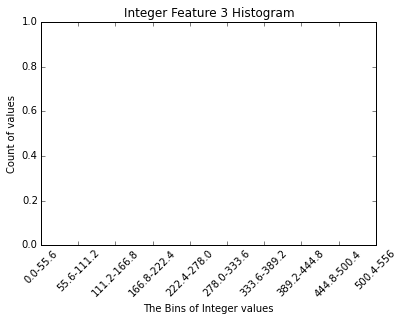

In [108]:
#Category_columns_histograms(debug)
#x1,y1,z1 = cat_columns_histogram(debug)
x,y = int_columns_histograms(debug)

#cat_columns_histogram(debug)

In [31]:
int_columns_basic_summary_stats(debug)

Column # 2: Mean=3.769      Stdev=10.451     Variance=109.228   
Column # 3: Mean=112.864    Stdev=401.523    Variance=161220.427
Column # 4: Mean=40.745     Stdev=538.819    Variance=290325.723
Column # 5: Mean=8.280      Stdev=10.836     Variance=117.426   
Column # 6: Mean=17592.599  Stdev=65797.898  Variance=4329363390.243
Column # 7: Mean=139.685    Stdev=371.776    Variance=138217.462
Column # 8: Mean=15.222     Stdev=65.460     Variance=4285.075  
Column # 9: Mean=13.575     Stdev=46.542     Variance=2166.120  
Column #10: Mean=125.295    Stdev=286.416    Variance=82033.945 
Column #11: Mean=0.620      Stdev=0.677      Variance=0.458     
Column #12: Mean=2.400      Stdev=4.630      Variance=21.436    
Column #13: Mean=0.938      Stdev=5.328      Variance=28.384    
Column #14: Mean=11.608     Stdev=52.045     Variance=2708.636  


In [32]:
def print_column_summary_details(col_num, kurtosis, skewness):
    print("Column #%2d: Kurtosis=%-10.3f Skewness=%-10.3f" % (col_num, kurtosis, skewness))

def int_columns_detail_stats(data):
    df = sqlContext.createDataFrame(data)
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_integer_col_num(col_num):            
            col = df["_%s" % col_num]
            k_col = sqlFunctions.kurtosis(col)
            k_result = df.select(k_col.alias("kurtosis")).collect()[0]
            s_col = sqlFunctions.skewness(col)
            s_result = df.select(s_col.alias("skewness")).collect()[0]
            print_column_summary_details(col_num, k_result.kurtosis, s_result.skewness)

In [33]:
int_columns_detail_stats(debug)

Column # 2: Kurtosis=373.759    Skewness=13.045    
Column # 3: Kurtosis=100.708    Skewness=7.264     
Column # 4: Kurtosis=7426.228   Skewness=74.676    
Column # 5: Kurtosis=115.569    Skewness=5.891     
Column # 6: Kurtosis=115.043    Skewness=9.146     
Column # 7: Kurtosis=251.298    Skewness=11.409    
Column # 8: Kurtosis=4233.619   Skewness=42.413    
Column # 9: Kurtosis=5577.523   Skewness=68.854    
Column #10: Kurtosis=163.166    Skewness=9.010     
Column #11: Kurtosis=2.495      Skewness=1.125     
Column #12: Kurtosis=66.442     Skewness=6.399     
Column #13: Kurtosis=3362.307   Skewness=42.705    
Column #14: Kurtosis=5899.185   Skewness=67.003    


In [34]:
a = int_columns_histograms(debug)

Column 2 histogram
	Bins=[0.0, 55.6, 111.2, 166.8, 222.4, 278.0, 333.6, 389.2, 444.8, 500.40000000000003, 556]
	Counts=[55236, 295, 34, 10, 5, 3, 2, 0, 1, 1] (total=55587)
Column 3 histogram
	Bins=[-2.0, 1850.4, 3702.8, 5555.200000000001, 7407.6, 9260.0, 11112.400000000001, 12964.800000000001, 14817.2, 16669.600000000002, 18522]
	Counts=[98530, 1397, 52, 12, 7, 0, 1, 0, 0, 1] (total=100000)
Column 4 histogram
	Bins=[0.0, 6553.5, 13107.0, 19660.5, 26214.0, 32767.5, 39321.0, 45874.5, 52428.0, 58981.5, 65535]
	Counts=[80863, 11, 1, 20, 0, 0, 0, 0, 1, 2] (total=80898)
Column 5 histogram
	Bins=[0.0, 41.7, 83.4, 125.10000000000001, 166.8, 208.5, 250.20000000000002, 291.90000000000003, 333.6, 375.3, 417]
	Counts=[79210, 1178, 44, 8, 12, 6, 5, 0, 0, 3] (total=80466)
Column 6 histogram
	Bins=[0.0, 174112.8, 348225.6, 522338.39999999997, 696451.2, 870564.0, 1044676.7999999999, 1218789.5999999999, 1392902.4, 1567015.2, 1741128]
	Counts=[93216, 1145, 491, 218, 88, 44, 19, 11, 5, 3] (total=95240)
C